In [1]:
import numpy as np
from scipy.ndimage import correlate
import math
from skimage.segmentation import slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries, felzenszwalb
from skimage import img_as_ubyte
from skimage.future import graph

from my_imread import my_imread
from my_fspecial import my_fspecial

import os, sys
import time
import cv2
from matplotlib import pyplot as plt

from IPython.display import clear_output 

In [2]:
def LSC_superpixel(I, nseg, name):
    
    superpixelNum = nseg
    
    ratio = 0.075
    
    size = int(math.sqrt(((I.shape[0]*I.shape[1]) / nseg)))

    superpixelLSC = cv2.ximgproc.createSuperpixelLSC(
            I,
            region_size=size,
            ratio=0.075)
    
    
    start=time.time()
    superpixelLSC.iterate()
    superpixelLSC.enforceLabelConnectivity(min_element_size=25)
    segments = superpixelLSC.getLabels()
    end = time.time()
    
    elapsed_time = (end-start)
    
    superpixel_image = mark_boundaries(I, segments) *255
    
    cv2.imwrite(os.path.join('results', 'LSC', name+'_'+str(nseg)+'.png'), superpixel_image)
    
    return segments, elapsed_time



def SLIC_superpixel(I, nseg, name):
    
    start=time.time()
    segments = slic(I, n_segments=nseg)
    end = time.time()
    
    elapsed_time = (end-start)

    superpixel_image = mark_boundaries(I, segments)*255

    cv2.imwrite(os.path.join('results', 'SLIC', name+'_'+str(nseg)+'.png'), superpixel_image)
        
    return segments, elapsed_time



def NormCut_superpixel(I, nseg, name):
    
    start=time.time()
    labels1 = slic(I,  n_segments=nseg)
    
    g = graph.rag_mean_color(I, labels1, mode='similarity')
    
    segments = graph.cut_normalized(labels1, g)
    end = time.time()
    
    elapsed_time = (end-start)
    
    
    superpixel_image = mark_boundaries(I, segments)*255
    
    cv2.imwrite(os.path.join('results', 'NCUT', name+'_'+str(nseg)+'.png'), superpixel_image)
    
    return segments, elapsed_time
    
            
def FH_superpixel(I, nseg, name):
    
    start=time.time()
    segments = felzenszwalb(img, min_size= int(47000 / nseg))  ### by collecting multile samples of segmentation 
                                                                ## for different min_size argument, I found that the 
                                                                ## no. of segments is approximaately N/min_size where
                                                                ## N is between 42000 and 52000... hence I take avg. of
                                                                ## 47000... nseg is the desired number of segments
    end = time.time()
    
    elapsed_time = (end-start)
    
    superpixel_image = mark_boundaries(I, segments)*255
    
    cv2.imwrite(os.path.join('results', 'FH', name+'_'+str(nseg)+'.png'), superpixel_image)
    
    return segments, elapsed_time



def SEEDS_superpixel(I, nseg, name):
    
    I_new = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    height,width,channels = I_new.shape
    
    superpixelNum = nseg
    
    start=time.time()
    seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, superpixelNum, 4, 2, 5)
    seeds.iterate(I_new)
    segments = seeds.getLabels()
    end = time.time()
    
    elapsed_time = (end-start)
    
    superpixel_image = mark_boundaries(I, segments) *255
    
    cv2.imwrite(os.path.join('results', 'SEEDS', name+'_'+str(nseg)+'.png'), superpixel_image)
    
    return segments, elapsed_time


# Run and Record

In [3]:
def calc_UE(l, GT, UE):

    temp = np.array(l)

    overlap_with_GT = [[] for x in range(temp.max()+1)]

    row, col = temp.shape
    
    for r in range(row):
        for c in range(col):
            overlap_with_GT[l[r,c]].append(GT[r,c])
        
    ue = 0
        
    for i in range(len(overlap_with_GT)):
        gt = np.array(overlap_with_GT[i])
        if len(np.unique(gt)) > 1:
            ue += 1
        
    UE.append(ue/(temp.max()))
    
    return UE


def calc_BR(l, GT, BR):
    
    segBounds = find_boundaries(l, mode='inner').astype(np.uint8)
    GTBounds = find_boundaries(GT, mode='inner').astype(np.uint8)
    
    rows, cols = GTBounds.shape
    
    total_GT_bound_pixels = 0
    recalled_pixels = 0
    
    for r in range(rows):
        for c in range(cols):
            
            if GTBounds[r,c] == True:
                
                total_GT_bound_pixels += 1  #### this is a boundary pixel
                
                stop_check = 0
                
                for i in range(-2, 3):
                    if r+i >=0 and r+i < rows:
                        for j in range(-2, 3):
                            if c+j >=0 and c+j < cols:
                                if segBounds[r+i, c+j] == True: ## Ground Truth boundary pixel is close to 
                                                                ## atleast one segment boundary
                                    recalled_pixels += 1
                                    stop_check = 1
                                    break
                                
                    if stop_check:
                        break
    
    BR.append(recalled_pixels/total_GT_bound_pixels)
    
    return BR
    

In [4]:
def run_LSC(I, name, n_superpixels, GT):

    labels = []
    time = []
    UE = []
    BR = []
    
    for nseg in n_superpixels:
        
        l, t = LSC_superpixel(I, nseg, name)
        
        labels.append(l)
        time.append(t)
        
        ####################### Undersegmentation Error #########################             
        UE = calc_UE(l, GT, UE)
        BR = calc_BR(l, GT, BR)
        
        
    return labels, time, UE, BR
        
        

def run_SLIC(I, name, n_superpixels, GT):

    labels = []
    time = []
    UE = []
    BR = []
    
    for nseg in n_superpixels:
        
        l, t = SLIC_superpixel(I, nseg, name)
        
        labels.append(l)
        time.append(t)

        ####################### Undersegmentation Error #########################             
        UE = calc_UE(l, GT, UE)
        BR = calc_BR(l, GT, BR)
        
    return labels, time, UE, BR
    
    
    
def run_NormCut(I, name, n_superpixels, GT):

    labels = []
    time = []
    UE = []
    BR = []
    
    for nseg in n_superpixels:
        
        l, t = NormCut_superpixel(I, nseg, name)
        
        labels.append(l)
        time.append(t) 
        
        ####################### Undersegmentation Error #########################             
        UE = calc_UE(l, GT, UE)
        BR = calc_BR(l, GT, BR)
        
    return labels, time, UE, BR
    
    
    
def run_FH(I, name, n_superpixels, GT):

    labels = []
    time = []
    UE = []
    BR = []
    
    for nseg in n_superpixels:
        
        l, t = FH_superpixel(I, nseg, name)
        
        labels.append(l)
        time.append(t) 
        
        ####################### Undersegmentation Error #########################             
        UE = calc_UE(l, GT, UE)
        BR = calc_BR(l, GT, BR)
        
    return labels, time, UE, BR  


def run_SEEDS(I, name, n_superpixels, GT):
    
    labels = []
    time = []
    UE = []
    BR = []
    
    for nseg in n_superpixels:
        
        l, t = SEEDS_superpixel(I, nseg, name)
        
        labels.append(l)
        time.append(t) 
        
        ####################### Undersegmentation Error #########################             
        UE = calc_UE(l, GT, UE)
        BR = calc_BR(l, GT, BR)
        
    return labels, time, UE, BR  

# MAIN

In [5]:
import glob, re

RGBimages = list(sorted(glob.glob(os.path.join('images', '*.*'))))


collect_runtime_LSC = []
collect_UE_LSC = []
collect_BR_LSC = []

collect_runtime_SLIC = []
collect_UE_SLIC = []
collect_BR_SLIC = []

collect_runtime_NormCut = []
collect_UE_NormCut = []
collect_BR_NormCut = []

collect_runtime_FH = []
collect_UE_FH = []
collect_BR_FH = []

collect_runtime_SEEDS = []
collect_UE_SEEDS = []
collect_BR_SEEDS = []


doLSC = 1
doSLIC = 1
doNormCut = 1
doFH = 1
doSEEDS = 1


ln = len(RGBimages)

#ln = 100

print("Number of Images: ", ln, '\n')


global_start = time.time()

for im in range(ln): 
        
    ImageName, _ = os.path.splitext(os.path.basename(RGBimages[im]))
    
    print('Count; ', im, ' Image Name: ', ImageName)

        
    img = my_imread(os.path.join('images', ImageName + '.jpg'))
    

    human_labels = np.zeros((img.shape[0], img.shape[1]), dtype=int)
    
    segfile = os.path.join('BSDS300-human','BSDS300','human','common', ImageName+'.seg')
    
    label_list = []
    
    with open(segfile) as f:
        for line in f:
            lin = line.split(' ')
            if not re.match("^[a-zA-Z]*$", lin[0]):  #### it's a line containing labels
                lin = [int(x) for x in lin]
                label_list.append(lin)
    
    
    for i in range(len(label_list)):
        
        lbl = label_list[i][0]
        row = label_list[i][1]
        from_col = label_list[i][2]
        to_col = label_list[i][3]
        
        for col in range(from_col, to_col+1):
            human_labels[row][col] = lbl

     

    
    
    ######################################################################
    # At this point, we have the ground truth segmentation for the image 
    # as 'human_labels'. Now, we will obtain segmentation from various 
    # algortihms and compare...
    ######################################################################

    
    ### apply gaussian 
    gaus = my_fspecial('gaussian', 3)
    
    I = correlate(img.astype(np.float64),
                gaus.reshape(gaus.shape[0], gaus.shape[1], 1),
                mode="constant").round().astype(np.uint8)
    
    print(I.shape)
    
            
    human_superpixel_image = mark_boundaries(I, human_labels) *255
    cv2.imwrite(os.path.join('results', 'GroundTruth', ImageName+'.png'), human_superpixel_image)
    
        
    n_superpixels = range(50, 550, 50)
    
    try:
        if doLSC:
            print('running LSC')
            LSC_labels, LSC_times, LSC_UE, LSC_BR = run_LSC(I, ImageName, n_superpixels, human_labels)

        if doSLIC:
            print('running SLIC')
            SLIC_labels, SLIC_times, SLIC_UE, SLIC_BR = run_SLIC(I, ImageName, n_superpixels, human_labels)

        if doNormCut:
            print('running NormCut')
            NormCut_labels, NormCut_times, NormCut_UE, NormCut_BR = run_NormCut(I, ImageName, n_superpixels, human_labels)
            
        if doFH:
            print('running FH')
            FH_labels, FH_times, FH_UE, FH_BR = run_FH(I, ImageName, n_superpixels, human_labels)

        if doSEEDS:
            print('running SEEDS')
            SEEDS_labels, SEEDS_times, SEEDS_UE, SEEDS_BR = run_SEEDS(I, ImageName, n_superpixels, human_labels)          
    
    except:
            print("Failed for image# : ", im, ' ', ImageName, '\n')
            continue

    
    global_end = time.time()

            
    print('\nTotal Elapsed Time so far...: ', (global_end-global_start)/60, ' min.')
    print('\n')

        
    collect_runtime_LSC.append(LSC_times)
    collect_UE_LSC.append(LSC_UE)
    collect_BR_LSC.append(LSC_BR)
    
    collect_runtime_SLIC.append(SLIC_times)
    collect_UE_SLIC.append(SLIC_UE)
    collect_BR_SLIC.append(SLIC_BR)

    collect_runtime_NormCut.append(NormCut_times)
    collect_UE_NormCut.append(NormCut_UE)
    collect_BR_NormCut.append(NormCut_BR)
    
    collect_runtime_FH.append(FH_times)
    collect_UE_FH.append(FH_UE)
    collect_BR_FH.append(FH_BR)
    
    collect_runtime_SEEDS.append(SEEDS_times)
    collect_UE_SEEDS.append(SEEDS_UE)
    collect_BR_SEEDS.append(SEEDS_BR)

Number of Images:  300 

Count;  0  Image Name:  100075
(321, 481, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  1.5547455112139383  min.


Count;  1  Image Name:  100080
(481, 321, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  2.971379498640696  min.


Count;  2  Image Name:  100098
(321, 481, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  4.808143599828084  min.


Count;  3  Image Name:  101085
(481, 321, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  6.505946326255798  min.


Count;  4  Image Name:  101087
(481, 321, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  7.99601624806722  min.


Count;  5  Image Name:  102061
(481, 321, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time

C:\Users\SHUBHAM007\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: divide by zero encountered in longlong_scalars


running FH
running SEEDS

Total Elapsed Time so far...:  32.677632602055866  min.


Count;  22  Image Name:  112082
(321, 481, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  34.124769401550296  min.


Count;  23  Image Name:  113009
(481, 321, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  35.562250367800395  min.


Count;  24  Image Name:  113016
(321, 481, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  36.95910028219223  min.


Count;  25  Image Name:  113044
(321, 481, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  38.327830171585084  min.


Count;  26  Image Name:  117054
(321, 481, 3)
running LSC
running SLIC
running NormCut
running FH
running SEEDS

Total Elapsed Time so far...:  39.826641245683035  min.


Count;  27  Image Name:  118020
(321, 481, 3)
running LSC
runn

## Take average over multiple runs (i.e., multiple images)

In [13]:
average_runtime_LSC = None 
average_runtime_SLIC = None 
average_runtime_NormCut = None 
average_runtime_FH = None
average_runtime_SEEDS = None


def list_avg(lst):
    
    lim = 20
    
    b = [0 for x in range(len(lst[0]))]

    for i in range(len(b)):
        s = 0
        for j in range(len(lst[:lim])):
            s += lst[j][i]
            
        b[i] = s/len(lst[:lim])
     
    return b


if doLSC:
    average_runtime_LSC = list_avg(collect_runtime_LSC)
    average_UE_LSC = list_avg(collect_UE_LSC)
    average_BR_LSC = list_avg(collect_BR_LSC)

if doSLIC:
    average_runtime_SLIC = list_avg(collect_runtime_SLIC)
    average_UE_SLIC = list_avg(collect_UE_SLIC)
    average_BR_SLIC = list_avg(collect_BR_SLIC)

if doNormCut:
    average_runtime_NormCut = list_avg(collect_runtime_NormCut)
    average_UE_NormCut = list_avg(collect_UE_NormCut)
    average_BR_NormCut = list_avg(collect_BR_NormCut)

if doFH:
    average_runtime_FH = list_avg(collect_runtime_FH)
    average_UE_FH = list_avg(collect_UE_FH)
    average_BR_FH = list_avg(collect_BR_FH)
    
    
if doSEEDS:
    average_runtime_SEEDS = list_avg(collect_runtime_SEEDS)
    average_UE_SEEDS = list_avg(collect_UE_SEEDS)
    average_BR_SEEDS = list_avg(collect_BR_SEEDS)

## Plot Results

In [14]:
def plot_metrics(for_LSC, for_SLIC, for_NormCut, for_FH, for_SEEDS):
    lgnd = []

    if for_LSC:
        plt.plot(n_superpixels, for_LSC, 's-')
        lgnd.append('LSC')

    if for_SLIC:
        plt.plot(n_superpixels, for_SLIC, '*-')
        lgnd.append('SLIC')

    if for_NormCut:
        plt.plot(n_superpixels, for_NormCut, '^-')
        lgnd.append('Normalized Cut')

    if for_FH:
        plt.plot(n_superpixels, for_FH, '+-')
        lgnd.append('Felzenszwalb')

        
    if for_SEEDS:
        plt.plot(n_superpixels, for_SEEDS, 'D-')
        lgnd.append('SEEDS')
        
        
    return lgnd 



In [15]:
fs = 20

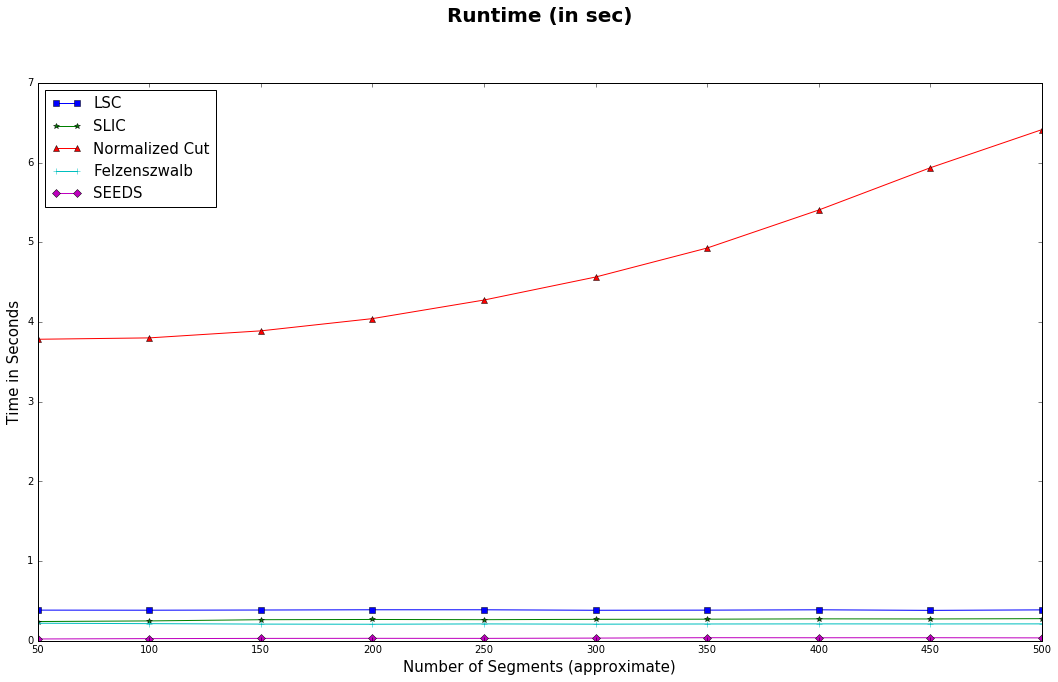

In [16]:
clear_output()

plt.figure(figsize=(18, 10))
plt.title("Runtime (in sec)", fontsize=fs, y=1.1, fontweight='bold')

lgnd = plot_metrics(average_runtime_LSC, average_runtime_SLIC, average_runtime_NormCut, average_runtime_FH, 
                    average_runtime_SEEDS)

plt.legend(lgnd, loc='upper left', prop={'size': 15})
plt.xlabel('Number of Segments (approximate)', fontsize=15)
plt.ylabel('Time in Seconds', fontsize=15)

plt.show()

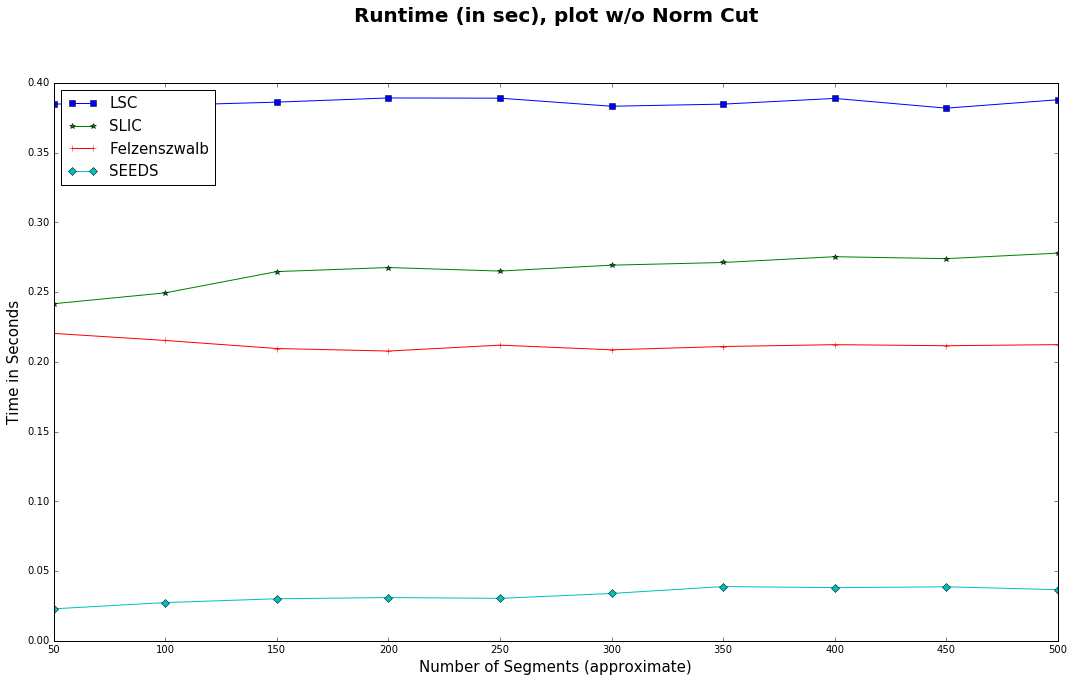

In [17]:
clear_output()

plt.figure(figsize=(18, 10))
plt.title("Runtime (in sec), plot w/o Norm Cut", fontsize=fs, y=1.1, fontweight='bold')

lgnd = plot_metrics(average_runtime_LSC, average_runtime_SLIC, None, average_runtime_FH, 
                    average_runtime_SEEDS)

plt.legend(lgnd, loc='upper left', prop={'size': 15})
plt.xlabel('Number of Segments (approximate)', fontsize=15)
plt.ylabel('Time in Seconds', fontsize=15)

plt.show()

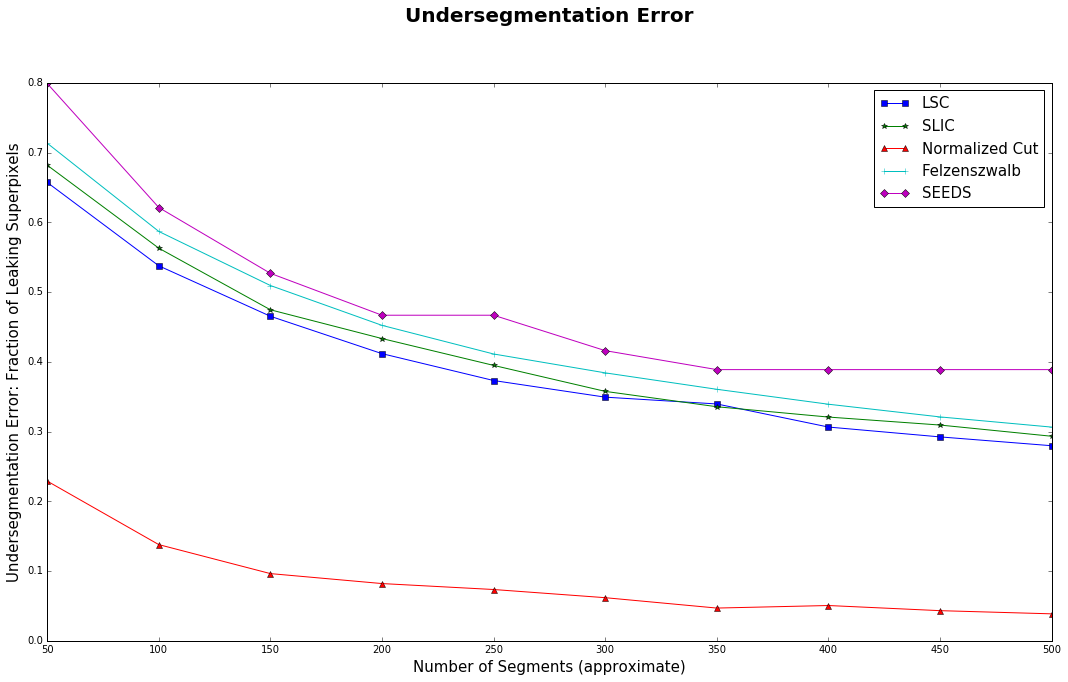

In [18]:
clear_output()

plt.figure(figsize=(18, 10))
plt.title("Undersegmentation Error", fontsize=fs, y=1.1, fontweight='bold')

lgnd = plot_metrics(average_UE_LSC, average_UE_SLIC, average_UE_NormCut, average_UE_FH, average_UE_SEEDS)

plt.legend(lgnd, loc='upper right', prop={'size': 15})
plt.xlabel('Number of Segments (approximate)', fontsize=15)
plt.ylabel('Undersegmentation Error: Fraction of Leaking Superpixels', fontsize=15)

plt.show()

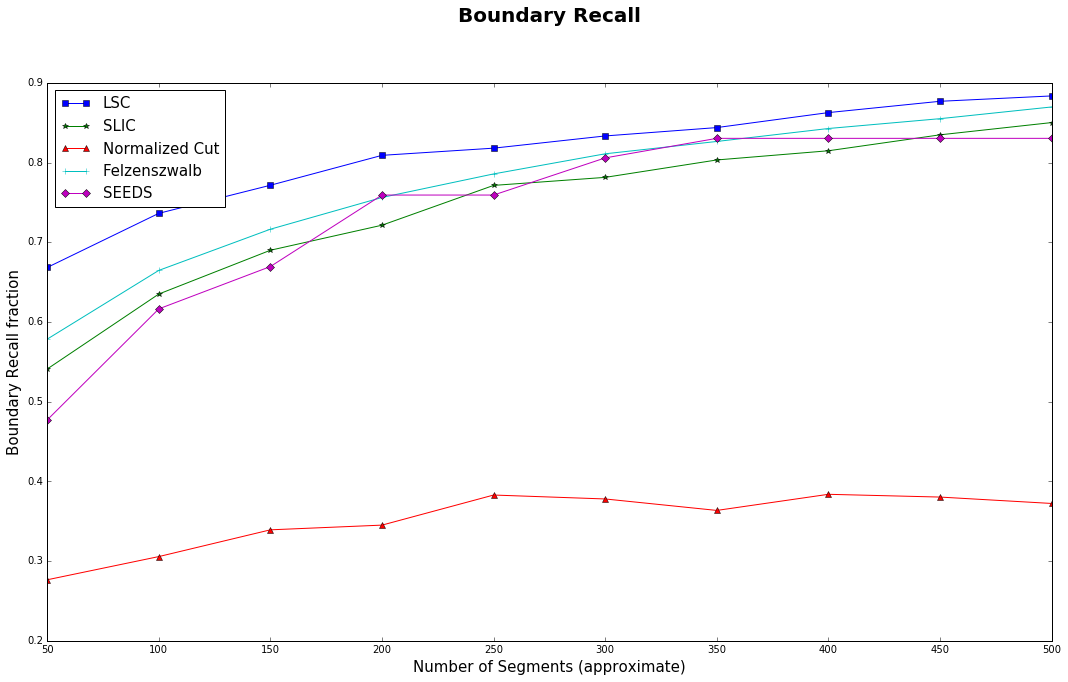

In [19]:
clear_output()

plt.figure(figsize=(18, 10))
plt.title("Boundary Recall", fontsize=fs, y=1.1, fontweight='bold')

lgnd = plot_metrics(average_BR_LSC, average_BR_SLIC, average_BR_NormCut, average_BR_FH, average_BR_SEEDS)

plt.legend(lgnd, loc='upper left', prop={'size': 15})
plt.xlabel('Number of Segments (approximate)', fontsize=15)
plt.ylabel('Boundary Recall fraction', fontsize=15)

plt.show()